<a href="https://colab.research.google.com/github/rashadkp/ecg_classification_using_resnet/blob/master/ecg_resnet_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/ljbkusters/python-wigner-distribution.git

In [ ]:
cd python-wigner-distribution

/content/python-wigner-distribution


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install .

In [33]:
!pip install wfdb
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import signal
import wfdb
import pandas as pd
# import wignerdpy
# from wignerdpy.toolkits import signal_toolkit

In [34]:
Y = pd.read_csv('/content/drive/MyDrive/Physionet/ptb-xl/ptbxl_database.csv', index_col='ecg_id')

In [35]:
Y = Y[:987]

In [36]:
path = '/content/drive/MyDrive/Physionet/ptb-xl/'

In [37]:
import sys
import torch
import torch.fft
import numpy as np
from scipy import signal

In [38]:
def load_raw_data(df, path):
    data = []
    for i, filename in enumerate(df.filename_hr):
        record, meta = wfdb.rdsamp(path + filename, channels=[1])
        data.append(record)
        # Print and overwrite the previous message
        sys.stdout.write(f"\rRecord {filename} is read successfully.")
        sys.stdout.flush()
    # Print a new line at the end to move the cursor to the next line
    print()

    # Convert the list to a PyTorch tensor
    data = np.array(data)


    return data

In [ ]:
X = load_raw_data(Y,path)

Record records500/00000/00512_hr is read successfully.


In [39]:
def check_norm(d):
    if isinstance(d, str):
        d = eval(d)  # Convert string representation of dictionary to dictionary
        first_key = list(d.keys())[0]
        if first_key == 'NORM':
            return 0
        else:
            return 1
    else:
        return np.nan

# Apply the function to the 'scp_codes' column
Y['norm_indicator'] = Y['scp_codes'].apply(check_norm)

# Convert the 'norm_indicator' column to a numpy array
labels = Y['norm_indicator'].values


In [ ]:
Z=Z[:,:,0]

In [ ]:
sample_data = X[0]

In [ ]:
X = X[:,:,0]


In [41]:
from scipy.ndimage import zoom
import os

In [ ]:
from scipy.ndimage import zoom

Wigner Ville Distribution

In [ ]:
wigner_dist, max_freq = wignerdpy.wigner_distribution(sample_data, sample_frequency = 500)

In [ ]:
def twodimrep(signal):
  ret=[]
  for i in range(len(signal)):
    k,_ = wignerdpy.wigner_distribution(signal[i], sample_frequency = 500)
    resized_matrix = zoom(k, (224/5000, 224/5000))
    sys.stdout.write(f"\rRecord {i} is converted to matrix successfully.")
    sys.stdout.flush()
    ret.append(resized_matrix)
  return ret

In [ ]:
A =X[:10]

In [ ]:
im = twodimrep(X)

Record 499 is converted to matrix successfully.

In [ ]:
SAM = twodimrep(Z)

Record 99 is converted to matrix successfully.

RESNET

In [42]:
wvd_data = np.load("/content/drive/MyDrive/ECG_TRAINING_CHECKPOINT/wvd_of_ecg.npy")

In [49]:
train_data = wvd_data[:700]
train_label = labels[:700]
test_data = wvd_data[700:987]
test_label = labels[700:987]

In [ ]:
pip install torch torchvision numpy wandb

In [51]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Assuming `data_list` is your list of 224x224 matrices and `labels` is the numpy array of size 987x1
# data_list = ...  # Your data here
# labels = ...     # Your labels here

# Convert to numpy arrays
data_array = np.stack(train_data)
labels_array = train_label.flatten()

class SingleToThreeChannel:
    def __call__(self, image):
        return image.repeat(3, 1, 1)
# Transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    SingleToThreeChannel(),
])

# Create dataset and dataloader
dataset = CustomDataset(data_array, labels_array, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [52]:
import wandb

wandb.init(project="resnet50-classification")


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [53]:
import torch.nn as nn
import torchvision.models as models

# Load pretrained ResNet50
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Assuming 2 classes

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [54]:
import torch.optim as optim
from torch.optim import lr_scheduler
import copy


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

num_epochs = 25
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0


for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataset)
    epoch_acc = running_corrects.double() / len(dataset)

    wandb.log({"loss": epoch_loss, "accuracy": epoch_acc})

    print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

    # Deep copy the model if the current accuracy is the best so far
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    scheduler.step()

# Load best model weights
model.load_state_dict(best_model_wts)

# Save the best model
torch.save(model.state_dict(), "best_model.pth")

print(f"Training complete. Best accuracy: {best_acc:.4f}")


Epoch 0/24, Loss: 0.7201, Accuracy: 0.4886
Epoch 1/24, Loss: 0.6506, Accuracy: 0.6043
Epoch 2/24, Loss: 0.5379, Accuracy: 0.7443
Epoch 3/24, Loss: 0.3382, Accuracy: 0.9029
Epoch 4/24, Loss: 0.1398, Accuracy: 0.9857
Epoch 5/24, Loss: 0.0472, Accuracy: 1.0000
Epoch 6/24, Loss: 0.0256, Accuracy: 0.9986
Epoch 7/24, Loss: 0.0141, Accuracy: 1.0000
Epoch 8/24, Loss: 0.0154, Accuracy: 1.0000
Epoch 9/24, Loss: 0.0133, Accuracy: 1.0000
Epoch 10/24, Loss: 0.0156, Accuracy: 1.0000
Epoch 11/24, Loss: 0.0105, Accuracy: 1.0000
Epoch 12/24, Loss: 0.0127, Accuracy: 1.0000
Epoch 13/24, Loss: 0.0138, Accuracy: 1.0000
Epoch 14/24, Loss: 0.0143, Accuracy: 1.0000
Epoch 15/24, Loss: 0.0118, Accuracy: 1.0000
Epoch 16/24, Loss: 0.0119, Accuracy: 1.0000
Epoch 17/24, Loss: 0.0117, Accuracy: 1.0000
Epoch 18/24, Loss: 0.0112, Accuracy: 1.0000
Epoch 19/24, Loss: 0.0114, Accuracy: 1.0000
Epoch 20/24, Loss: 0.0088, Accuracy: 1.0000
Epoch 21/24, Loss: 0.0103, Accuracy: 1.0000
Epoch 22/24, Loss: 0.0130, Accuracy: 1.000

testing

In [30]:
import torch
import torchvision.models as models

# Load the model architecture
model = models.resnet50()

# Modify the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Assuming 2 classes

# Load the best model weights
model.load_state_dict(torch.load("/content/drive/MyDrive/ECG_TRAINING_CHECKPOINT/best_model.pth"))

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set the model to evaluation mode
model.eval()
from PIL import Image
import numpy as np
from torchvision import transforms

# Custom transform to convert single channel to 3 channels
class SingleToThreeChannel:
    def __call__(self, image):
        return image.repeat(3, 1, 1)

# Define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    SingleToThreeChannel(),  # Convert single channel to 3 channels
])

# Example single input (replace this with your actual input)
single_input = wvd_data[986]  # Dummy single-channel input

# Apply the transformations
input_tensor = transform(single_input)

# Add batch dimension
input_tensor = input_tensor.unsqueeze(0)

# Move the input tensor to the GPU if available
input_tensor = input_tensor.to(device)


In [ ]:
print(labels)

In [55]:
# Run inference
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted = torch.max(outputs, 1)

# Convert the predicted class index to a class label (0 or 1)
predicted_class = predicted.item()

print(f"Predicted class: {predicted_class}")


Predicted class: 0


Test data

In [56]:
import torch
import torchvision.models as models
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import numpy as np

# Load the model architecture
model = models.resnet50()

# Modify the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # Assuming 2 classes

# Load the best model weights
model.load_state_dict(torch.load("/content/drive/MyDrive/ECG_TRAINING_CHECKPOINT/best_model.pth"))

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Assuming you have your test data and labels as test_data and test_labels respectively

# List to store predicted labels
all_predicted = []
# List to store ground truth labels
all_labels = []



# Iterate over test data
for single_input in test_data:
    # Apply transformations
    input_tensor = transform(single_input)
    input_tensor = input_tensor.unsqueeze(0)
    input_tensor = input_tensor.to(device)

    # Run inference
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)

    # Append predicted and ground truth labels
    all_predicted.append(predicted.item())
    # Assuming test_labels is a list of ground truth labels
    all_labels.append(test_label[len(all_predicted)-1])  # assuming same length

# Convert lists to numpy arrays
all_predicted = np.array(all_predicted)
all_labels = np.array(all_labels)

# Create confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predicted)

print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[100  46]
 [ 57  84]]


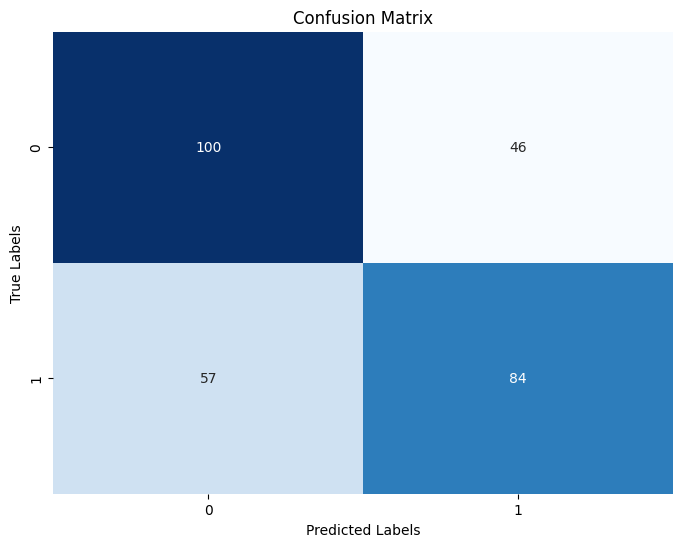

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [58]:
# Calculate accuracy
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

# Calculate precision
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)

print(f'Accuracy: {accuracy*100:.2f}')
print(f'Precision for class 0: {precision[0]:.2f}')
print(f'Precision for class 1: {precision[1]:.2f}')


Accuracy: 64.11
Precision for class 0: 0.64
Precision for class 1: 0.65
